# Creating your own light curves using custom aperture photometry

## Learning Goals

By the end of this tutorial, you will:

* Understand how to use aperture photometry to turn a series of two-dimensional images into a one-dimensional time series.
* Be able to determine the most useful aperture for photometry on a _Kepler/K2_ target.
* Create your own light curve for a single quarter/campaign of _Kepler/K2_ data.

## Introduction

This tutorial is part of a series on handling _Kepler_ and _K2_ data with Astropy and Lightkurve. As you have seen earlier in this series, Lightkurve provides utilities that allow you to create your own light curve from a _Kepler_ or _K2_ target pixel file. In this tutorial, we'll look at the principles behind the process of performing aperture photometry on a target. Then we'll get into specifics and learn how to customize our apertures to get the most out of our data.

## Imports

We'll use [Lightkurve](https://docs.lightkurve.org/) for downloading and handling _Kepler_ data throughout this tutorial. We'll also use [NumPy](https://numpy.org/) to handle arrays for aperture masks.

In [1]:
import lightkurve as lk
import numpy as np
%matplotlib inline

## 1. Background

### 1.1 Introduction to _Kepler_ photometry

When you search for _Kepler_ or _K2_ light curves in the data archive, you can either access simple aperture photometry (SAP) light curves (for example, see the [_Kepler_ Data Processing Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/KSCI-19081-003-KDPH.pdf), Section 6.3.6), or presearch data conditioning simple aperture photometry (PDCSAP) light curves (for example, [Stumpe et al., 2012](https://arxiv.org/pdf/1203.1382.pdf), [Smith et al., 2012](https://arxiv.org/pdf/1203.1383.pdf)). You can also access the orignal target pixel files (TPFs) from which such light curves were extracted. TPFs are useful for inspecting the calibrated pixels, but when you're doing science, you usually just want to look at a light curve. This tutorial covers how to use TPFs to _create_ light curves. There are many reasons why you might want to produce your own light curve, which we'll cover in [Section 1.3](#1.3-Why-don't-we-just-use-the-data-from-MAST?). But more fundamentally, it's important to know how the data you're using is produced. In this tutorial, we'll walk through the basics of photometry and then learn how to apply it to _Kepler_ TPFs, producing light curves just like the ones produced by the official _Kepler_ pipeline.

Before we get into it, it's important to note that we're only going to be performing photometry on one quarter at a time. Combining _Kepler_ Quarters is not trivial: because the telescope rotated by 90° every quarter, the same star would fall on different pixels every fourth quarter. Different pixels have different sensitivities, so the size of the TPFs downloaded for a single target changes between adjacent quarters. It's certainly possible to combine multiple quarters of *Kepler* data, or campaigns of _K2_ data, and you can read more about it in a different tutorial. We won't cover quarter stitching here, however.

We also won't cover systematics correction in this tutorial. Light curves created using custom aperture photometry will still include systematic noise from various sources, such as spacecraft motion. You can read more about noise and noise corrections in other tutorials in this series.

### 1.2 Aperture photometry

In this tutorial, we're going to explore photometry in a practical context by creating our own time series data. But first, we'll go through a quick introduction of some of the theory behind it. Photometry is defined as the process of measuring the brightness of an astronomical object. Specifically, we'll be doing time series photometry: measuring that brightness over time. Telescopes like _Kepler_ use charge-coupled device (CCD) cameras ([_Kepler_ Instrument Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/KSCI-19033-002-instrument-hb.pdf), Section 4) to take images of their targets at regular intervals — this interval is known as the cadence — and we perform photometry to turn each image into a flux measurement.

In _Kepler_ and _K2_ data, each targeted object has a TPF, which is used to store the raw pixel data from which a light curve can be produced. _Kepler_'s pixels are 4x4 arcseconds large, and all stars take up less angular space than this as point sources in the sky. So, theoretically, we could track the flux of a single pixel over time, and call that our light curve. But light that falls on a CCD is spread onto surrounding pixels, proportional to its brightness.

Let's have a look at a TPF to see what a star actually looks like in _Kepler_ pixel data. The following line of code downloads the 30-minute long cadence light curve for KIC 7461601 from MAST. You can read more about using Lightkurve to download data in a separate tutorial.

In [2]:
tpf_example = lk.search_targetpixelfile("KIC 7461601", author="Kepler", cadence='long', quarter=10).download()

<AxesSubplot:title={'center':'Target ID: 7461601, Cadence: 39049'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

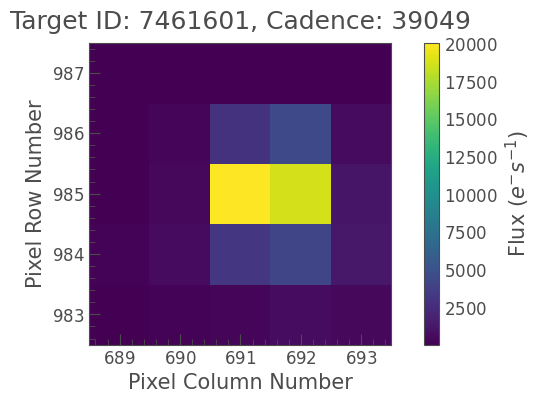

In [3]:
tpf_example.plot();

You can see how the light from this star is spread out across the TPF. The process of choosing which pixels to use for photometry is referred to as defining an aperture. By adding together the flux in multiple pixels, we get a more accurate measurement of the object's brightness.

TPFs are designed to be big enough such that the vast majority of a target's flux is captured within the available pixels. Because light from a star doesn't spread out like a rectangle (we'll talk about this more below), each TPF has pixels which we won't need to use for our photometry. In the example above, the star has a [_Kepler_ magnitude](https://keplerscience.arc.nasa.gov/the-kepler-space-telescope.html#flux-calibration) of 13.4; this is analogous to a visual magnitude, and defined based on higher resolution photometry taken prior to the _Kepler_ mission. For a star this bright, we can pick out six pixels by eye that almost certainly contain signal. Fainter targets are spread out across fewer pixels, and brighter targets may cover well over 20 pixels. Extremely bright targets will saturate the detector, making it very hard to perform photometry on them. We won't be covering saturated stars in this tutorial; if you're interested in working with them, the [Halophot](https://github.com/hvidy/halophot/) Python package is a good place to start.

So what about the pixels we don't use? Think of a grainy photograph: we observe the same thing in all CCD data, but it's harder to recognize by eye in photographs from telescopes with large pixels. This grainy noise is called "shot noise," and arises from fluctuations in the current that powers an electronic photon-collecting device. For aperture photometry, we need to worry about shot noise because it dominates what we see in the "background" of an image, that is, the light we see in pixels that don't have any light from our target. In reality, most pixels will be some kind of combination of "signal" and "background." When we choose our aperture for photometry, we're looking to optimize the amount of signal we collect, and minimize the noise contribution from the background.

This is what the aperture used by the _Kepler_ pipeline looks like for our example star:

<AxesSubplot:title={'center':'Target ID: 7461601, Cadence: 39049'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

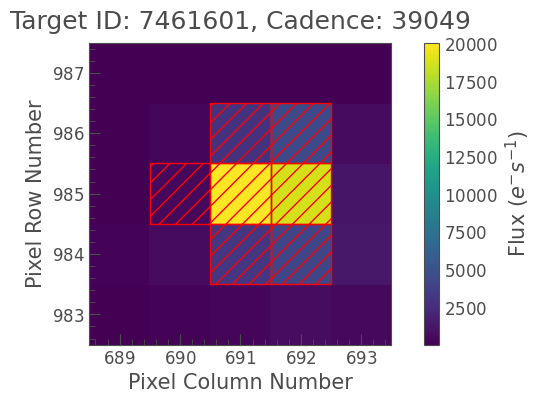

In [4]:
tpf_example.plot(aperture_mask='pipeline');

You might not expect the star's aperture to be this shape — stars are point sources, after all. In many cases, stars in _Kepler_ will look circular, as we'd expect. However, at the edge of the focal plane, some targets may appear smeared in one direction. And even for a star with circular spread, the aperture may be a different shape. The way the spread of light interacts with the detector is defined by something called the point spread function (PSF), or pixel response function (PRF). _Kepler_'s PSF/PRF is described in detail in Section 3.5 of the [_Kepler_ Instrument Handbook](https://archive.stsci.edu/kepler/manuals/KSCI-19033-001.pdf).

We've looked at a basic example in this section, but as we'll see later in this tutorial, it can be hard to determine the best aperture for a given target by eye. Choosing the best aperture for your target can be something of a balancing act: using a larger aperture will minimize the effects of PSF changes and spacecraft motion, but conversely it increases the presence of shot noise. This is why _Kepler_ and _K2_ data were processed with an "optimal aperture." Brightness, PSF, shot noise, crowding, and many other factors went into predicting the optimal aperture for producing a SAP or PDCSAP light curve with NASA's _Kepler_ and _K2_ pipelines. You can read more about the process of creating these apertures in [Smith et al., 2016](https://ui.adsabs.harvard.edu/abs/2016PASP..128l4501S/abstract), which is equivalent to Chapter 7 of the [_Kepler_ Data Processing Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/KSCI-19081-003-KDPH.pdf).

### 1.3 Why not just use published light curves?

There are several reasons why we might want to create our own light curve from scratch, rather than using the readily available data. One of the main reasons is contamination: particularly in crowded fields, we might find multiple signals in one light curve, meaning there are multiple targets in the TPF. In that case, we would want to make our own light curve using a smaller aperture, to make sure that we're only picking up the signal from our target star. Alternatively, we might want to use our TPF to produce a serendipitous light curve for a contaminating star, especially if it doesn't have its own SAP/PDCSAP light curve available.

Another reason we might want to produce our own light curves is to minimize noise. Recall that some pixels might be dominated by shot noise over signal. If we find that some of the pixels in a _Kepler_ pipeline aperture have more noise than signal, we can make our own aperture to see what happens if we exclude those pixels.

Finally, we might want to produce a light curve for a star that doesn't have SAP/PDCSAP data available at all. This could be a star in the full-frame images (FFIs), or the superstamps ([_Kepler_ Archive Manual](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/archive_manual.pdf), Sections 2.3.3 and 2.2.1). This is less likely to come up with _Kepler/K2_ data, but all of these tools will come in handy when working with _TESS_ full-frame images. There are hundreds of thousands of stars in the _TESS_ field of view that weren't targeted and don't have readily available light curves. Custom aperture photometry is perfectly suited for inspecting individual targets in the _TESS_ FFIs.

### 1.4 Choosing an aperture

In NASA's _Kepler_ and _K2_ pipelines, the process of determining apertures is automated ([_Kepler_ Data Processing Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/KSCI-19081-003-KDPH.pdf), Part II). Here, we'll manually create our own apertures.

Without any knowledge of which pixels contain light from our target, the most basic approach is to look at individual pixels and manually determine which pixels to work with. Working offline, we can use Lightkurve's TPF `interact()` function, which is a convenient way to inspect one or more pixels at a time. Another recommended way to define an aperture is by defining a median flux value and only selecting pixels at a certain sigma above that threshold. In the tutorial, we'll look at using Lightkurve's built-in functionality to perform this.

In most situations, a threshold mask will be the best choice for custom aperture photometry, as it doesn't involve trial and error beyond finding the best sigma value. However, if you're dealing with multiple bright objects in one TPF, a manual mask may be the better option.

Both of these methods are most useful when dealing with small amounts of data, such as looking at a handful of individual objects. When working with large datasets, it's advisable to use the pipeline aperture, as this will be sufficient in the majority of cases with _Kepler_ and _K2_. However, if you're processing a large amount of stars which were not targeted during either mission — such as FFI or superstamp data — a good approach would be to experiment with multiple threshold apertures for each target and see which one produces the best results.

## 2. Getting Started

### 2.1 Doing photometry with the pipeline aperture

We're going to use the built-in functions in Lightkurve for aperture photometry. You may have encountered `to_lightcurve()` in other tutorials in this series. In this section, we'll explore a number of ways to use this function for custom aperture photometry — but first, let's do a quick review of the function at its most basic.

We'll start by downloading a target pixel file. We're going to use _Kepler_ long cadence data to look at KIC 2437317, a star which shows brightness variations due to rotation ([Reinhold & Gizon, 2015](https://www.aanda.org/articles/aa/pdf/2015/11/aa26216-15.pdf)). We're downloading Quarter 10, as there was minimal data loss during this quarter ([_Kepler_ Data Characteristics Manual](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/Data_Characteristics.pdf), Section 4.1).

In [5]:
tpf = lk.search_targetpixelfile("KIC 2437317", author="Kepler", cadence="long", quarter=10).download(quality_bitmask="hard")

Before we do photometry on this star, let's see what we're working with by plotting the TPF:

<AxesSubplot:title={'center':'Target ID: 2437317, Cadence: 39049'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

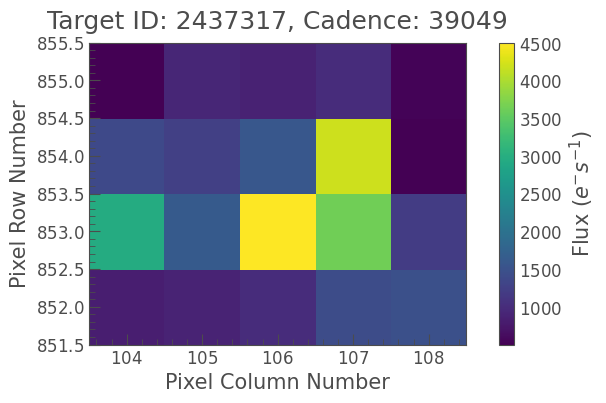

In [6]:
tpf.plot();

Notice that this TPF is more crowded than the one we looked at in Section 1. We can still point out which pixels probably contain the star's signal, and which ones are dominated by noise. However, there's also a background star in this TPF: the bright pixel to the left. We want to avoid picking up signal from that star.

We can use Lightkurve to plot the pipeline aperture:

<AxesSubplot:title={'center':'Target ID: 2437317, Cadence: 39049'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

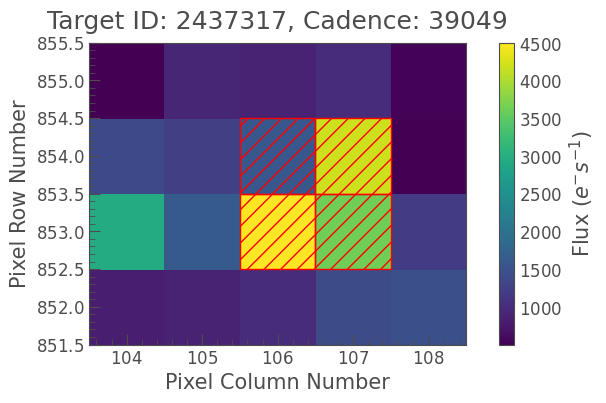

In [7]:
tpf.plot(aperture_mask='pipeline');

The pipeline aperture is small in this case, but it avoids capturing any light from the background star. Now we can generate the light curve that results from using that aperture as follows:

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

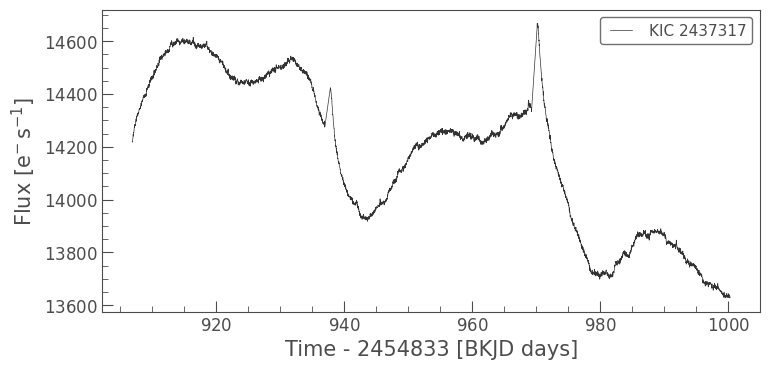

In [8]:
lc = tpf.to_lightcurve(aperture_mask="pipeline")
lc.plot();

The signal you can see here is caused by rotational modulation.

Notice the spikes around 935 and 970 days. These coincide with breaks in the data collection during which _Kepler_ was pointed at Earth to downlink data. These breaks are associated with small focus changes of the _Kepler_ telescope, which are caused by the thermal effects associated with pointing _Kepler_'s antenna towards Earth. These artifical peaks are a form of systematic noise. We'll see more evidence of systematic noise in the light curves we look at throughout this tutorial. As we're only focused on performing photometry, we won't do any light curve corrections to remove such noise, but you can read more about how to do so in other tutorials.


### 2.2 Adjusting the aperture

Lightkurve's `to_lightcurve()` function has an `aperture_mask` keyword, which changes the aperture used to perform photometry. Later we'll look at creating our own apertures, but first, let's look at the three standard arguments this keyword takes:

* `'pipeline'`: this is the default option, which will return the same as above.
* `'threshold'`: select all pixels which have a flux higher than 3 standard deviations above a median brightness.
* `'all'`: use every pixel in the frame for photometry.

We can do a side-by-side comparison of the resulting light curves by normalizing them as follows:

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

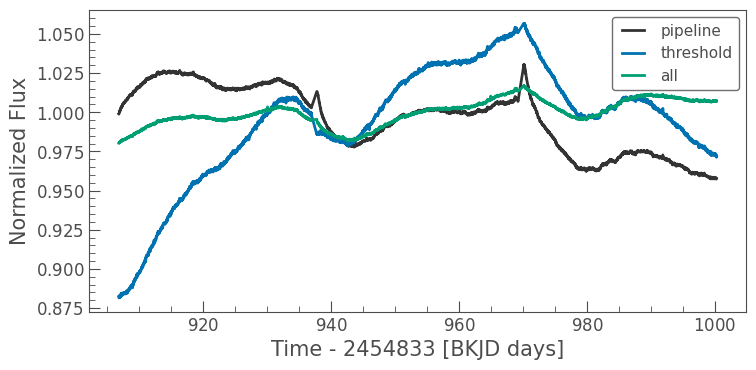

In [9]:
ax = tpf.to_lightcurve(aperture_mask='pipeline').normalize().plot(label='pipeline', linewidth=2);
tpf.to_lightcurve(aperture_mask='threshold').normalize().plot(ax=ax, label='threshold', linewidth=2);
tpf.to_lightcurve(aperture_mask='all').normalize().plot(ax=ax, label='all', linewidth=2);

Our star is fairly bright, with a _Kepler_ magnitude of 14.6, so we don't see much variation in the noise levels between these three light curves. But as you can see, using all of the pixels means including light from the background star which dilutes our star's signal, making the rotation harder to detect by eye. On the other hand, using all of the pixels reduces the systematic noise near days 935 and 970, because telescope focus changes have less impact when a large aperture mask is used.

The threshold mask light curve looks less diluted than the one using all of the pixels, but it still looks markedly different from the light curve from the pipeline aperture. We can use another of Lightkurve's functions to see why this is the case:


In [10]:
tpf.create_threshold_mask()

array([[False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False,  True, False],
       [False, False, False, False, False]])

This is Lightkurve's default 3 standard deviations threshold mask, and for this TPF there's only one pixel with flux above that cutoff. Note how Lightkurve apertures work: pixels marked `True` in the aperture mask array are the ones that are used for photometry.

We'll make our own Boolean masks like this later. First, let's play around with the `create_threshold_mask()` function and try to reproduce the pipeline mask. Keeping in mind that the TPF we looked at above has many more bright pixels than faint ones, we can expect a bright median, so let's try using a lower threshold:

In [11]:
custom_threshold_mask = tpf.create_threshold_mask(threshold=1)
custom_threshold_mask

array([[False, False, False, False, False],
       [False, False,  True,  True, False],
       [False, False,  True,  True, False],
       [False, False, False, False, False]])

Now we've recreated the pipeline mask, which we can use to perform photometry again. As we'd expect, it produces the same results as the pipeline mask:

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

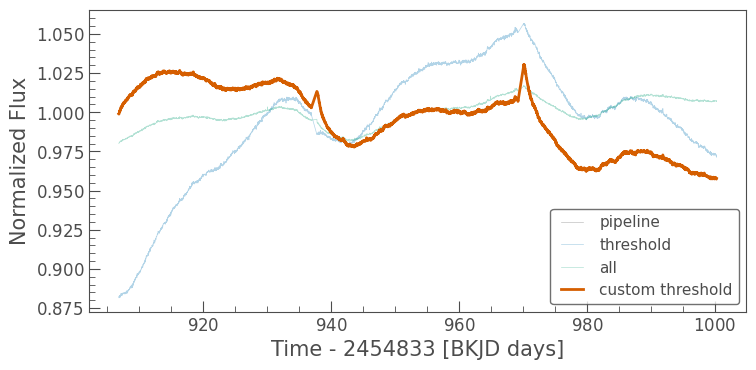

In [12]:
ax = tpf.to_lightcurve(aperture_mask='pipeline').normalize().plot(label='pipeline', alpha=.3)
tpf.to_lightcurve(aperture_mask='threshold').normalize().plot(ax=ax, label='threshold', alpha=.3)
tpf.to_lightcurve(aperture_mask='all').normalize().plot(ax=ax, label='all', alpha=.3)
tpf.to_lightcurve(aperture_mask=custom_threshold_mask).normalize().plot(ax=ax, label='custom threshold', linewidth=2);

## 3. Manual Custom Apertures

### 3.1 Creating a custom threshold aperture with Lightkurve

In this section we'll look at performing aperture photometry with a custom aperture. We're going to switch to a different star, KIC 2437901. This star is an oscillating red giant (Colman et al., in prep), but we're interested in it because it was processed using a large TPF, and there's a second bright star captured in the image.

Have a look at the TPF:

In [13]:
tpf_crowded = lk.search_targetpixelfile("KIC 2437901", author="Kepler", cadence="long", quarter=10).download(quality_bitmask="hard")

<AxesSubplot:title={'center':'Target ID: 2437901, Cadence: 39049'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

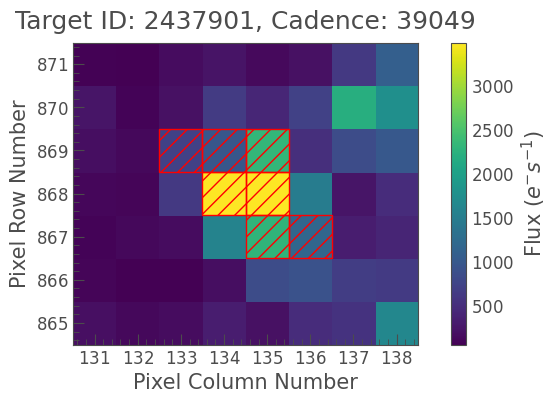

In [14]:
tpf_crowded.plot(aperture_mask='pipeline');

We're going to focus on that star in the top right. It's not captured in the pipeline aperture, but it's a serendipitous find in the TPF, so we can perform our own photometry on it with a custom aperture. Let's see what the threshold mask looks like for this TPF:

In [15]:
tpf_crowded.create_threshold_mask(threshold=1)

array([[False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False,  True,  True,  True, False, False],
       [False, False, False,  True,  True, False, False, False],
       [False, False, False,  True,  True, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False]])

We can plot this on top of the TPF, like so:

<AxesSubplot:title={'center':'Target ID: 2437901, Cadence: 39049'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

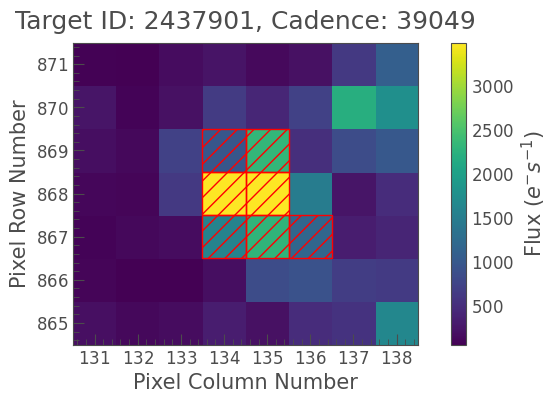

In [16]:
tpf_crowded.plot(aperture_mask=tpf_crowded.create_threshold_mask(threshold=1));

No luck.  Our custom aperture still selects the bright star in the center.  When the thresholding method yields multiple contiguous regions, the default behavior of the `create_threshold_mask` method is to return the region closest to the center.  We can modify this behavior by passing a `reference_pixel` argument to specify the region we are most interested in. The argument is defined such that `reference_pixel=(0,0)` refers to the lower left corner. Hence, we can select the region in the upper right corner as follows:

<AxesSubplot:title={'center':'Target ID: 2437901, Cadence: 39049'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

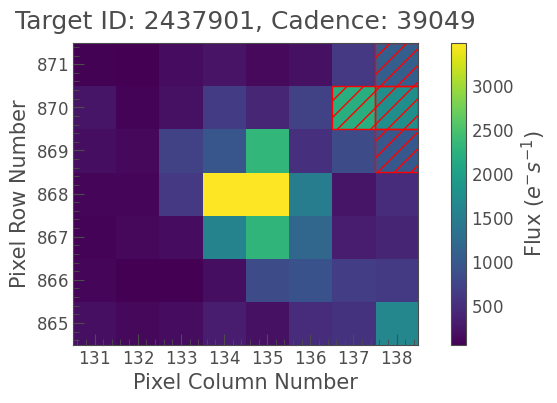

In [17]:
custom_mask = tpf_crowded.create_threshold_mask(threshold=1, reference_pixel=(7,7))
tpf_crowded.plot(aperture_mask=custom_mask);

Now we can perform aperture photometry using this mask:

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

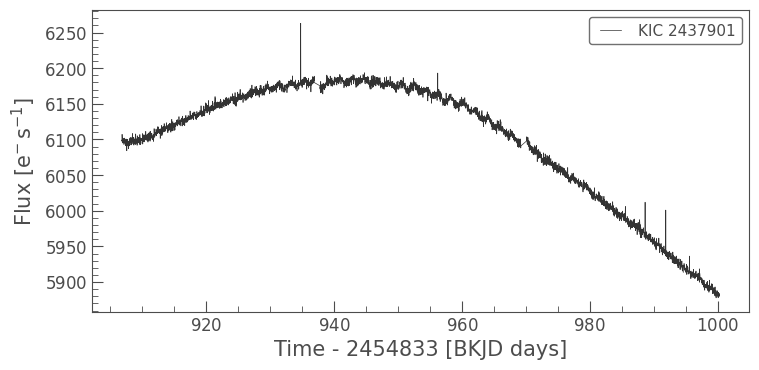

In [18]:
lc_background_star = tpf_crowded.to_lightcurve(aperture_mask=custom_mask)
lc_background_star.plot();

Looks like there's some signal in this star — a two-day period! In fact, this star is KIC 2437948, a likely binary (Colman et al., in prep).

We could make that signal even clearer by being more selective, and manually assigning `True` to the individual pixels we want to use. The downside to this method is that it takes time and manual work to create a mask by hand. However, when working with small volumes of data, such as one quarter or campaign at a time, or one star, this method can produce good results. In what follows, we will demonstrate three alternative methods to create a mask by hand.

### 3.2 Creating a custom aperture with NumPy arrays

We can use NumPy to create an aperture mask array by hand. For this star, it would make sense to select a 3x3 zone in the top right of the image. This can be tricky: 2D NumPy arrays index the y-axis first, and are printed with the zeroth y index at the top of the array, whereas a plotted array places zero at the bottom, as with a normal plot.

In [19]:
custom_mask = np.zeros((tpf_crowded[0].shape[1:]), dtype='bool')
custom_mask[-3:,5:] = True

custom_mask

array([[False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False,  True,  True,  True],
       [False, False, False, False, False,  True,  True,  True],
       [False, False, False, False, False,  True,  True,  True]])

Let's plot the custom mask on top of the TPF. Notice that the y-axis in our array appears reversed, as described above. When handling images and NumPy arrays, it's good practice to plot them every time, and make sure you're seeing what you expect.

<AxesSubplot:title={'center':'Target ID: 2437901, Cadence: 39049'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

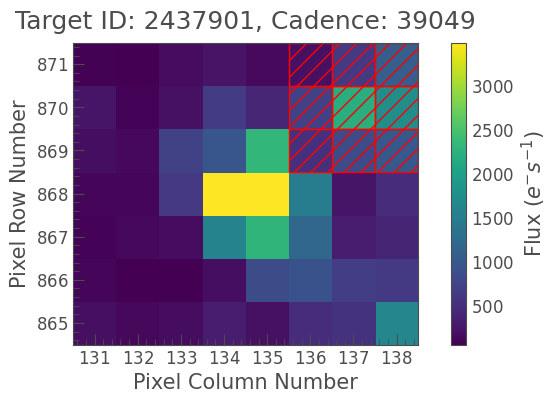

In [20]:
tpf_crowded.plot(aperture_mask=custom_mask);

### 3.3 "Cutting out" a background star

Using Lightkurve's `cutout()` function, we can emulate the process of creating a threshold mask on only the pixels we're interested in. This method is only suitable for large TPFs with a clearly separated background star, like the case of KIC 2437901 and KIC 2437948.

Let's start by cutting out those 3x3 pixels we just used as an aperture mask:

<AxesSubplot:title={'center':'Target ID: 2437901, Cadence: 39049'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

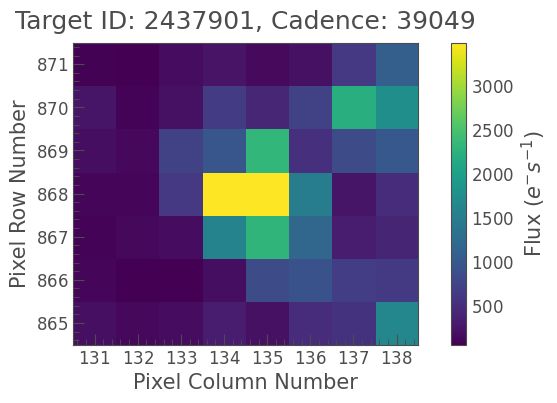

In [21]:
tpf_crowded.plot();

In [22]:
tpf_cut = tpf_crowded.cutout(center=(8,7))

<AxesSubplot:title={'center':'Target ID: 2437901_CUTOUT, Cadence: 39049'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

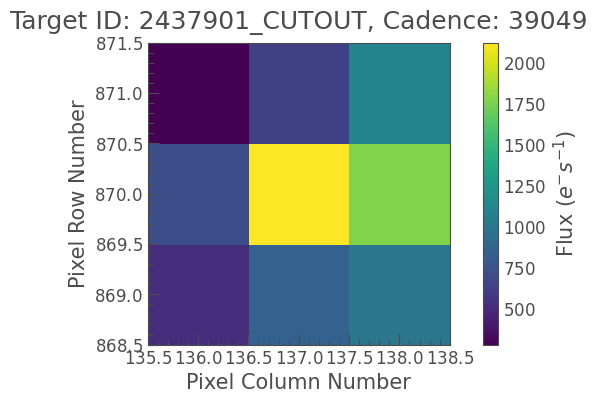

In [23]:
tpf_cut.plot();

This is still a `TargetPixelFile` object, so we can use all of the same functions:

In [24]:
tpf_cut.create_threshold_mask(threshold=1)

array([[False, False, False],
       [False,  True, False],
       [False, False, False]])

Unfortunately, the threshold mask only selects one pixel here. But with a smaller TPF, it's also more convenient to select individual pixels for our mask:

In [25]:
cut_mask = np.zeros(tpf_cut[0].shape[1:], dtype='bool')
cut_mask[:,1] = True
cut_mask[1,2] = True

cut_mask

array([[False,  True, False],
       [False,  True,  True],
       [False,  True, False]])

<AxesSubplot:title={'center':'Target ID: 2437901_CUTOUT, Cadence: 39049'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

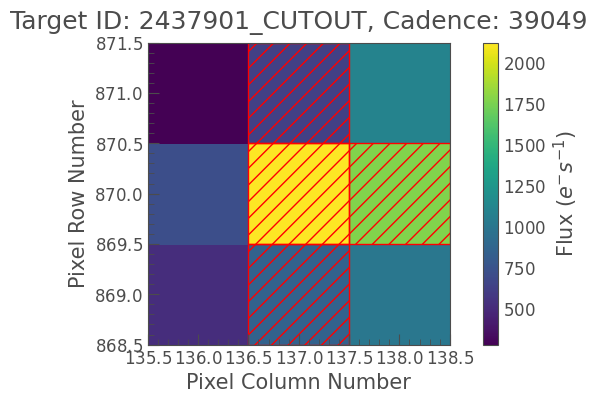

In [26]:
tpf_cut.plot(aperture_mask=cut_mask);

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

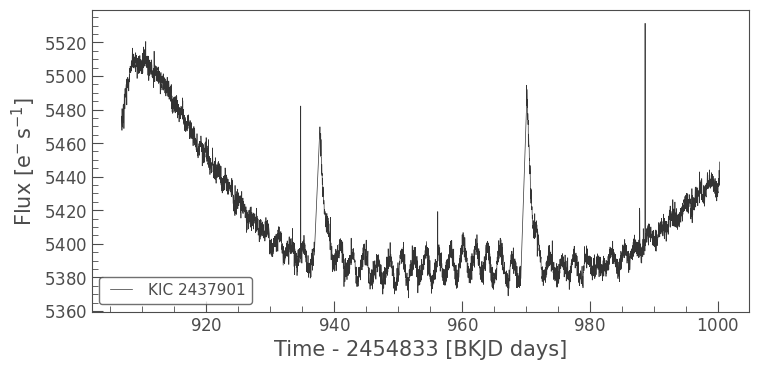

In [27]:
lc_background_star_cut = tpf_cut.to_lightcurve(aperture_mask=cut_mask)
lc_background_star_cut.plot();

And there's our signal again, nice and clear!

### 3.4 Creating a custom aperture using the `tpf.interact` tool

Finally, it is good to know that there is interactive functionality in Lightkurve to create a mask.  We cannot demonstrate it in this static tutorial, but you can try it yourself in a local notebook by running `tpf.interact()`. This will bring up an interactive panel which allows you to select the pixels you want using mouse clicks. Next, press "Save Lightcurve" in the bottom left of the panel. This will export your custom aperture light curve to a FITS file in your working directory. The file name follows a similar convention to official _Kepler_ data products. For example, the file name for the example above is `kplr002437901-2011271113734_lpd-targ-custom-lc.fits`.

## About this Notebook

**Author:** [Isabel Colman](http://orcid.org/0000-0001-8196-516X) (`isabel.colman@sydney.edu.au`)  

**Updated on:** 2020-09-15

## Citing Lightkurve and Astropy

If you use `lightkurve` or `astropy` for published research, please cite the authors. Click the buttons below to copy BibTeX entries to your clipboard.

In [28]:
lk.show_citation_instructions()

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>